In [1]:
import numpy as np
from tqdm import tqdm
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt
import pdb

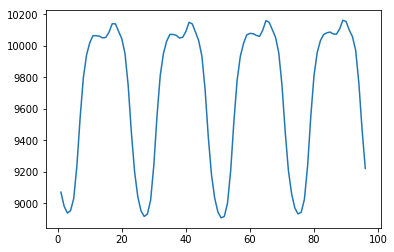

In [2]:
df = pd.read_csv('AESO_2020_demand_price.csv')
HE = []
end_index = df.shape[0]//(48 * 2) + 1
for day in range(1, end_index):
    for hour in range(1, (2 * 48) + 1):
        HE.append(hour)
df['HE'] = HE
df = df.drop(df.columns[[0, 2]], axis = 1)
df = df.set_index('HE', drop = True)
df = df.groupby('HE', as_index=True).mean()
df_to_plot = df.drop(df.columns[[0]], axis = 1)
plt.plot(df_to_plot);

In [3]:
alberta_avg_power_price = np.array(df.iloc[7:48+7, 0])
alberta_avg_demand = np.array(df.iloc[7:48+7, 1])

(48,)


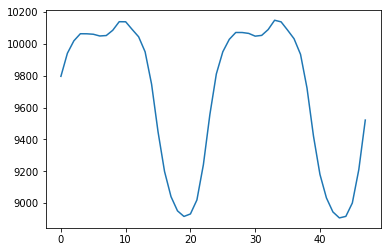

In [4]:
print(alberta_avg_demand.shape)
plt.plot(alberta_avg_demand);

In [5]:
# https://open.alberta.ca/dataset/d6205817-b04b-4360-8bb0-79eaaecb9df9/
# resource/4a06c219-03d1-4027-9c1f-a383629ab3bc/download/trans-motorized-
# vehicle-registrations-select-municipalities-2020.pdf
total_cars_in_alberta = 100
ev_market_penetration = 0.1
# SOC params
min_soc_by_8_am = 0.5
max_soc_allowed = 1
min_soc_allowed = 0.1
# Charging and discharging
charging_soc_addition_per_time_unit_per_ev = 0.15
discharging_soc_reduction_per_time_unit_per_ev = -0.15
# Power to the grid units in MWs
charging_soc_mw_addition_to_demand_per_time_unit_per_ev = 0.01
discharging_soc_mw_reduction_from_demand_per_time_unit_per_ev = 0.01
# Driving
driving_soc_reduction_per_time_unit_per_ev = 0.005
forecast_flag = False
n_percent_honesty = ['0.25', '0.5', '0.75', '1']

In [6]:
index_of_time = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,
                 15,16,17,18,19,20,21,22,23,24,25,26,
                 27,28,29,30,31,32,33,34,35,36,37,38,
                 39,40,41,42,43,44,45,46,47]
time_of_day = [8,9,10,11,12,13,14,15,16,17,18,19,20,
               21,22,23,0,1,2,3,4,5,6,7,8,9,10,11,12,
               13,14,15,16,17,18,19,20,21,22,23,0,1,2,
               3,4,5,6,7,8]

index_to_time_of_day_dict = {}
for item in range(len(index_of_time)):
    index_to_time_of_day_dict[index_of_time[item]] = time_of_day[item]
pprint(index_to_time_of_day_dict)

{0: 8,
 1: 9,
 2: 10,
 3: 11,
 4: 12,
 5: 13,
 6: 14,
 7: 15,
 8: 16,
 9: 17,
 10: 18,
 11: 19,
 12: 20,
 13: 21,
 14: 22,
 15: 23,
 16: 0,
 17: 1,
 18: 2,
 19: 3,
 20: 4,
 21: 5,
 22: 6,
 23: 7,
 24: 8,
 25: 9,
 26: 10,
 27: 11,
 28: 12,
 29: 13,
 30: 14,
 31: 15,
 32: 16,
 33: 17,
 34: 18,
 35: 19,
 36: 20,
 37: 21,
 38: 22,
 39: 23,
 40: 0,
 41: 1,
 42: 2,
 43: 3,
 44: 4,
 45: 5,
 46: 6,
 47: 7}


In [60]:
# Define experiment params
experiment_params = {'n_episodes': 50, 
                     'n_hours': 48, 
                     'n_divisions_for_soc': 10, 
                     'n_divisions_for_percent_honesty': 4,
                     'max_soc_allowed': 1,
                     'min_soc_allowed': 0.1,
                     'alpha': 0.001,
                     'epsilon': 0.1,
                     'gamma': 0.05,
                     'total_cars_in_alberta': 1000000,
                     'ev_market_penetration': 0.1,
                     'charging_soc_addition_per_time_unit_per_ev': 0.15, 
                     'discharging_soc_reduction_per_time_unit_per_ev': 0.15, 
                     'charging_soc_mw_addition_to_demand_per_time_unit_per_ev': 0.01, 
                     'discharging_soc_mw_reduction_from_demand_per_time_unit_per_ev': 0.01,
                     'driving_soc_reduction_per_km_per_ev': 0.005,
                     'alberta_average_demand': alberta_avg_demand,
                     'index_to_time_of_day_dict': index_to_time_of_day_dict,
                     'forecast_flag': forecast_flag,
                     'n_percent_honesty': n_percent_honesty
                    }

In [61]:
# Experiment function
class Experiment():
    
    def __init__(self, experiment_params={}):
        
        # Initialize all experiment params
        self.n_episodes = experiment_params.get('n_episodes')
        self.n_hours = experiment_params.get('n_hours')
        self.n_divisions_for_soc = experiment_params.get('n_divisions_for_soc')
        self.n_divisions_for_percent_honesty = experiment_params.get('n_divisions_for_percent_honesty')
        self.max_soc_allowed = experiment_params.get('max_soc_allowed')
        self.min_soc_allowed = experiment_params.get('in_soc_allowed')
        self.alpha = experiment_params.get('alpha')
        self.epsilon = experiment_params.get('epsilon')
        self.gamma = experiment_params.get('gamma')
        self.total_cars_in_alberta = experiment_params.get('total_cars_in_alberta')
        self.ev_market_penetration = experiment_params.get('ev_market_penetration')
        self.charging_soc_addition_per_time_unit_per_ev = experiment_params.get('charging_soc_addition_'\
                                                                           'per_time_unit_per_ev')
        self.discharging_soc_reduction_per_time_unit_per_ev = experiment_params.get('discharging_'\
                                                                               'soc_reduction_per_time_unit_per_ev')
        self.charging_soc_mw_addition_to_demand_per_time_unit_per_ev = experiment_params.get('charging_'\
                                                                                        'soc_mw_addition_to_demand_'\
                                                                                        'per_time_unit_per_ev') 
        self.discharging_soc_mw_reduction_from_demand_per_time_unit_per_ev = experiment_params.get('discharging_'\
                                                                                              'soc_mw_reduction_'\
                                                                                              'from_demand_per_'
                                                                                              'time_unit_per_ev')
        self.driving_soc_reduction_per_km_per_ev = experiment_params.get('driving_soc_reduction_per_km_per_ev')
        self.alberta_average_demand = experiment_params.get('alberta_average_demand')
        self.index_to_time_of_day_dict = experiment_params.get('index_to_time_of_day_dict')
        self.forecast_flag = experiment_params.get('forecast_flag')
        self.n_percent_honesty = experiment_params.get('n_percent_honesty')
            
        # Initialize q-value table    
        self.Q = self.initialize_action_value()
        
        # Display params
        print('Experiment parameters are: ')
        print(*experiment_params.items(), sep='\n')
            
    def start_experiment(self):
        """Initialize the experiment"""
        
        # Calculate the number of EVs in the province
        self.num_of_evs = self.total_cars_in_alberta * self.ev_market_penetration
             
        # Initialize an array of SOCs for each EV
        self.soc_of_evs = [0.5] * int(self.num_of_evs)
        
#         # Initialize the charge status of each EV
#         self.charge_status_of_evs = []
        
#         # Initialize the array of driving distance for each EV
#         self.driving_distance_of_evs = []
        
        # Initialize the last total load and average
        self.last_total_load = 0
        self.last_average = 1

    def run(self):
        """Main method to run the experiment with initialized params"""
        
        # Monitor the trace as the program runs
        #pdb.set_trace()
        
        self.reward_list = []
        self.average_list = []
        # Repeat for every episode
        for episode in tqdm(range(self.n_episodes), ncols=100):
            
            print('-----------------------Starting Episode----------------------------------------------')
            
            # Initialize the experiment
            self.start_experiment()
            
            # Calculate the percent honesty of people 
            percent_honest = np.random.choice(self.n_percent_honesty) #comes out as string
            
            # Repeat for every hour in the number of hours
            for hour in range(0, self.n_hours):
                
                # Calculate the percent honesty for the next hour
                if forecast_flag:
                    next_percent_honest = np.random.choice(self.n_percent_honesty, p = [0.25, 0.25, 0.25, 0.25])
                else:
                    next_percent_honest = np.random.choice(self.n_percent_honesty)
                    
                # Get the SOC division for each EV
                soc_div_index = self.get_division_index()
                
                # Get the indicator which shows whether each EV is
                # keeping to its original intention and make sure 
                # its applied randomly to each EV via shuffling
                status_evs = ([1] * int(self.num_of_evs * (1 - float(percent_honest))) 
                              + [0] * int(self.num_of_evs * float(percent_honest)))
                np.random.shuffle(status_evs)
                
                # Dictionary keeping track of what actions
                # were taken for each SOC division
                div_to_action_dict = {}
                
                # Loop for every SOC division
                for division in range(0, self.n_divisions_for_soc):
                    
                    # Extract the q-value for the division, hour, 
                    # and percent of EVs st
                    Q = self.Q[division][hour][int(float(percent_honest)/0.25 - 1)]
                    # Choose an action using a policy 
                    # (ex: epsilon-greedy)
                    action = self.choose_action(Q)
                    # Calculate the load for each SOC division 
                    #percent_honest = float(percent_honest) 
                    #next_percent_honest = float(next_percent_honest)
                    
                    if self.index_to_time_of_day_dict[hour] in [8,9,10,11,12,13,14,15]:
            
                        driving_distance_of_evs = abs(np.random.normal(10, 5, int(self.num_of_evs)))
                        soc_reduction_for_evs = self.driving_soc_reduction_per_km_per_ev * driving_distance_of_evs
                        for ii, soc in enumerate(self.soc_of_evs):
                            if soc_div_index[ii] == division:
                                self.soc_of_evs[ii] = soc - soc_reduction_for_evs[ii]
                        e_evs = 0
            
                    elif self.index_to_time_of_day_dict[hour] in [16,17,18,19,20,21,22,23,0,1,2]:

                        charging_load = 0
                        discharging_load = 0
                        driving_distance_of_evs = np.random.normal(5, 5, int(self.num_of_evs))

                        if action == 0:
                            #charging for soc
                            for ii, soc in enumerate(self.soc_of_evs):
                                if soc_div_index[ii] == division:
                                    if status_evs[ii] == 1:
                                        self.soc_of_evs[ii] = min(1, soc + self.charging_soc_addition_per_time_unit_per_ev)
                                        if self.soc_of_evs[ii] == 1:
                                            charging_load += 0
                                        else:
                                            charging_load += self.charging_soc_mw_addition_to_demand_per_time_unit_per_ev
                            #discharging for driving
                            soc_reduction_for_evs = self.driving_soc_reduction_per_km_per_ev * driving_distance_of_evs
                            for ii, soc in enumerate(self.soc_of_evs):
                                if soc_div_index[ii] == division:
                                    if status_evs[ii] == 0:
                                        self.soc_of_evs[ii] = soc - soc_reduction_for_evs[ii]
                        elif action == 1:
                            #discharging for soc
                            for ii, soc in enumerate(self.soc_of_evs):
                                if soc_div_index[ii] == division:
                                    if status_evs[ii] == 1:
                                        self.soc_of_evs[ii] = max(0, soc - self.discharging_soc_reduction_per_time_unit_per_ev)
                                        if self.soc_of_evs[ii] == 0:
                                            discharging_load += 0
                                        else:
                                            discharging_load += self.charging_soc_mw_addition_to_demand_per_time_unit_per_ev
                            #discharging for driving
                            soc_reduction_for_evs = self.driving_soc_reduction_per_km_per_ev * driving_distance_of_evs
                            for ii, soc in enumerate(self.soc_of_evs):
                                if soc_div_index[ii] == division:
                                    if status_evs[ii] == 0:
                                        self.soc_of_evs[ii] = soc - soc_reduction_for_evs[ii]
                        else:
                            #do nothing
                            #discharging for driving
                            soc_reduction_for_evs = self.driving_soc_reduction_per_km_per_ev * driving_distance_of_evs
                            for ii, soc in enumerate(self.soc_of_evs):
                                if soc_div_index[ii] == division:
                                    if status_evs[ii] == 0:
                                        self.soc_of_evs[ii] = soc - soc_reduction_for_evs[ii]

                        e_evs = charging_load - discharging_load

                    elif self.index_to_time_of_day_dict[hour] in [3,4,5,6,7]:

                        charging_load = 0
                        discharging_load = 0

                        if action == 0:
                            #charging for soc
                            for ii, soc in enumerate(self.soc_of_evs):
                                if soc_div_index[ii] == division:
                                    if status_evs[ii] == 1:
                                        self.soc_of_evs[ii] = min(1, soc + self.charging_soc_addition_per_time_unit_per_ev)
                                        if self.soc_of_evs[ii] == 1:
                                            charging_load += 0
                                        else:
                                            charging_load += self.charging_soc_mw_addition_to_demand_per_time_unit_per_ev
                        elif action == 1:
                            #discharging for soc
                            for ii, soc in enumerate(self.soc_of_evs):
                                if soc_div_index[ii] == division:
                                    if status_evs[ii] == 1:
                                        self.soc_of_evs[ii] = max(0, soc - self.discharging_soc_reduction_per_time_unit_per_ev)
                                        if self.soc_of_evs[ii] == 0:
                                            discharging_load += 0
                                        else:
                                            discharging_load += self.charging_soc_mw_addition_to_demand_per_time_unit_per_ev
                        else:
                            #do nothing
                            pass

                        if action == 0 or action == 1:
                            e_evs = charging_load - discharging_load
                        else:
                            e_evs = 0
                    
                    #print(f'Divsion {division}, hour {hour}, load = {load_from_division}')
                    # Populate division-to-action dictionary
                    # to preserve the action that was picked
                    # for each SOC division
                    div_to_action_dict[division] = (action, e_evs)
                
                # Get next hour based on current hour
                next_hour = self.get_next_hour(hour)
                
                # Calculate the total load based on
                # the loads from each SOC division
                total_load = 0
                for div in div_to_action_dict.keys():
                    total_load += div_to_action_dict[div][1]
                
                # Calculate the total power demand by adding the
                # power demand with the additional demand from EVs
                total_load += self.alberta_average_demand[self.index_to_time_of_day_dict[hour]]
                
                # Calculate the Peak-to-Average ratio and the reward
                # The reward 
                average = ((hour + 1 - 1) * self.last_average + total_load) / (hour + 1)
                reward = -max(total_load, self.last_total_load) / average
                
                # Update the qction-value function for each
                # SOC division, hour, and percent honesty
                for division in range(0, self.n_divisions_for_soc):

                    if next_hour <= 47:
                        delta = (reward 
                                 + self.gamma * np.max(self.Q[division][next_hour][int(float(next_percent_honest)//0.25-1)])
                                 - self.Q[division][hour][int(float(percent_honest)//0.25-1)][div_to_action_dict[division][0]])
                        self.Q[division][hour][int(float(percent_honest)//0.25-1)][div_to_action_dict[division][0]] += self.alpha * delta
                    else:
                        delta = reward - self.Q[division][hour][int(float(percent_honest)//0.25-1)][div_to_action_dict[division][0]]
                        self.Q[division][hour][int(float(percent_honest)/0.25-1)][div_to_action_dict[division][0]] += self.alpha * delta
                
                # Store the total load and peak-to-average
                # ratio
                self.last_total_load = total_load
                self.last_average = average
            print('Last total load: ', self.last_total_load)
            print('Last average: ', self.last_average)
            print('Reward: ', reward)
            self.reward_list.append(reward)
            self.average_list.append(average)
        
        print(self.Q)

    # Initialize action-values array
    def initialize_action_value(self):

#         dict_for_percent_honesty = {}
#         for item in self.n_percent_honesty:
#             dict_for_percent_honesty[item] = [0, 0, 0]
#         Q = self.n_divisions_for_soc * self.n_hours * [dict_for_percent_honesty]
#         Q = np.array(Q).reshape((self.n_divisions_for_soc, self.n_hours))
        Q = np.zeros(shape = (10, 48, 4, 3))

        return Q

    # Choose action using epsilon-greedy    
    def choose_action(self, Q):
        if np.random.random() < self.epsilon:
            action = np.random.choice([0, 1, 2])
        else:
            action = self.argmax(Q)
            
        return action
    
    def argmax(self, q_values):
        """argmax with random tie-breaking
        Args:
            q_values (Numpy array): the array of action values
        Returns:
            action (int): an action with the highest value
        """
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return np.random.choice(ties)

    # Get the load for each SOC division
    def get_load_from_action_for_div(self, 
                                     hour, 
                                     percent_honest, 
                                     action, 
                                     division, 
                                     soc_div_index, 
                                     status_evs, 
                                     next_percent_honest):
            
        if self.index_to_time_of_day_dict[hour] in [8,9,10,11,12,13,14,15]:
            
            driving_distance_of_evs = abs(np.random.normal(10, 5, int(self.num_of_evs)))
            soc_reduction_for_evs = self.driving_soc_reduction_per_km_per_ev * driving_distance_of_evs
            for ii, soc in enumerate(self.soc_of_evs):
                if soc_div_index[ii] == division:
                    self.soc_of_evs[ii] = soc - soc_reduction_for_evs[ii]
            e_evs = 0
            
        elif self.index_to_time_of_day_dict[hour] in [16,17,18,19,20,21,22,23,0,1,2]:
            
            charging_load = 0
            discharging_load = 0
            driving_distance_of_evs = np.random.normal(5, 5, int(self.num_of_evs))
            
            if action == 0:
                #charging for soc
                for ii, soc in enumerate(self.soc_of_evs):
                    if soc_div_index[ii] == division:
                        if status_evs[ii] == 1:
                            self.soc_of_evs[ii] = min(1, soc + self.charging_soc_addition_per_time_unit_per_ev)
                            if self.soc_of_evs[ii] == 1:
                                charging_load += 0
                            else:
                                charging_load += self.charging_soc_mw_addition_to_demand_per_time_unit_per_ev
                #discharging for driving
                soc_reduction_for_evs = self.driving_soc_reduction_per_km_per_ev * driving_distance_of_evs
                for ii, soc in enumerate(self.soc_of_evs):
                    if soc_div_index[ii] == division:
                        if status_evs[ii] == 0:
                            self.soc_of_evs[ii] = soc - soc_reduction_for_evs[ii]
            elif action == 1:
                #discharging for soc
                for ii, soc in enumerate(self.soc_of_evs):
                    if soc_div_index[ii] == division:
                        if status_evs[ii] == 1:
                            self.soc_of_evs[ii] = max(0, soc - self.discharging_soc_reduction_per_time_unit_per_ev)
                            if self.soc_of_evs[ii] == 0:
                                discharging_load += 0
                            else:
                                discharging_load += self.charging_soc_mw_addition_to_demand_per_time_unit_per_ev
                #discharging for driving
                soc_reduction_for_evs = self.driving_soc_reduction_per_km_per_ev * driving_distance_of_evs
                for ii, soc in enumerate(self.soc_of_evs):
                    if soc_div_index[ii] == division:
                        if status_evs[ii] == 0:
                            self.soc_of_evs[ii] = soc - soc_reduction_for_evs[ii]
            else:
                #do nothing
                #discharging for driving
                soc_reduction_for_evs = self.driving_soc_reduction_per_km_per_ev * driving_distance_of_evs
                for ii, soc in enumerate(self.soc_of_evs):
                    if soc_div_index[ii] == division:
                        if status_evs[ii] == 0:
                            self.soc_of_evs[ii] = soc - soc_reduction_for_evs[ii]
                
            e_evs = charging_load - discharging_load
            
        elif self.index_to_time_of_day_dict[hour] in [3,4,5,6,7]:
            
            charging_load = 0
            discharging_load = 0
            
            if action == 0:
                #charging for soc
                for ii, soc in enumerate(self.soc_of_evs):
                    if soc_div_index[ii] == division:
                        if status_evs[ii] == 1:
                            self.soc_of_evs[ii] = min(1, soc + self.charging_soc_addition_per_time_unit_per_ev)
                            if self.soc_of_evs[ii] == 1:
                                charging_load += 0
                            else:
                                charging_load += self.charging_soc_mw_addition_to_demand_per_time_unit_per_ev
            elif action == 1:
                #discharging for soc
                for ii, soc in enumerate(self.soc_of_evs):
                    if soc_div_index[ii] == division:
                        if status_evs[ii] == 1:
                            self.soc_of_evs[ii] = max(0, soc - self.discharging_soc_reduction_per_time_unit_per_ev)
                            if self.soc_of_evs[ii] == 0:
                                discharging_load += 0
                            else:
                                discharging_load += self.charging_soc_mw_addition_to_demand_per_time_unit_per_ev
            else:
                #do nothing
                pass
                
            if action == 0 or action == 1:
                e_evs = charging_load - discharging_load
            else:
                e_evs = 0
        
        return e_evs
    
    # Get the next hour based on
    # the current hour
    def get_next_hour(self, hour):

        if hour < 47:
            next_hour = hour + 1
        else:
            next_hour = 0
            
        return next_hour
    
    # Get the list of the SOC
    # division for each EV
    def get_division_index(self):
        
        soc_index = []
        for item in self.soc_of_evs:
            index = self.switch_index(item)
            soc_index.append(index)
            
        return soc_index
    
    # Get the SOC division
    # based on the SOC
    def switch_index(self, soc):
        
        if 0 < soc <= 0.1:
            index = 0
        elif soc <= 0.2:
            index = 1
        elif soc <= 0.3:
            index = 2
        elif soc <= 0.4:
            index = 3
        elif soc <= 0.5:
            index = 4
        elif soc <= 0.6:
            index = 5
        elif soc <= 0.7:
            index = 6
        elif soc <= 0.8:
            index = 7
        elif soc <= 0.9:
            index = 8
        elif soc <= 1:
            index = 9
        else:
            index = 'discharged'
            
        return index
    
    # Show the calculated policy
    def render_policy(self):
        pass

In [ ]:
# Run experiment
experiment = Experiment(experiment_params)
experiment.run()


  0%|                                                                        | 0/50 [00:00<?, ?it/s]

Experiment parameters are: 
('n_episodes', 50)
('n_hours', 48)
('n_divisions_for_soc', 10)
('n_divisions_for_percent_honesty', 4)
('max_soc_allowed', 1)
('min_soc_allowed', 0.1)
('alpha', 0.001)
('epsilon', 0.1)
('gamma', 0.05)
('total_cars_in_alberta', 1000000)
('ev_market_penetration', 0.1)
('charging_soc_addition_per_time_unit_per_ev', 0.15)
('discharging_soc_reduction_per_time_unit_per_ev', 0.15)
('charging_soc_mw_addition_to_demand_per_time_unit_per_ev', 0.01)
('discharging_soc_mw_reduction_from_demand_per_time_unit_per_ev', 0.01)
('driving_soc_reduction_per_km_per_ev', 0.005)
('alberta_average_demand', array([ 9796.02197802,  9940.9010989 , 10019.        , 10063.54945055,
       10063.20879121, 10060.35164835, 10049.46153846, 10052.23076923,
       10085.14285714, 10139.13186813, 10138.62637363, 10090.64835165,
       10044.3956044 ,  9950.0989011 ,  9746.67032967,  9446.98901099,
        9198.65934066,  9040.31868132,  8951.08791209,  8915.9010989 ,
        8931.57142857,  9019.


  2%|█▎                                                              | 1/50 [00:34<27:56, 34.22s/it]

Last total load:  10614.060769230568
Last average:  9791.483415750841
Reward:  -1.0844241967851957
-----------------------Starting Episode----------------------------------------------



  4%|██▌                                                             | 2/50 [00:51<23:13, 29.02s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------



  6%|███▊                                                            | 3/50 [01:11<20:48, 26.56s/it]

Last total load:  10479.260769230537
Last average:  9761.360915750893
Reward:  -1.0735450578741785
-----------------------Starting Episode----------------------------------------------



  8%|█████                                                           | 4/50 [01:33<19:13, 25.07s/it]

Last total load:  10103.780769230636
Last average:  9794.023415750866
Reward:  -1.053726451364662
-----------------------Starting Episode----------------------------------------------



 10%|██████▍                                                         | 5/50 [01:54<17:52, 23.84s/it]

Last total load:  9955.160769230752
Last average:  9815.164249084177
Reward:  -1.014263288580182
-----------------------Starting Episode----------------------------------------------



 12%|███████▋                                                        | 6/50 [02:12<16:17, 22.23s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------



 14%|████████▉                                                       | 7/50 [02:33<15:37, 21.81s/it]

Last total load:  10113.340769230772
Last average:  9789.34799908422
Reward:  -1.034083326020132
-----------------------Starting Episode----------------------------------------------



 16%|██████████▏                                                     | 8/50 [02:53<14:54, 21.30s/it]

Last total load:  10071.64076923077
Last average:  9736.025499084235
Reward:  -1.0577387599724466
-----------------------Starting Episode----------------------------------------------



 18%|███████████▌                                                    | 9/50 [03:11<13:41, 20.04s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------



 20%|████████████▌                                                  | 10/50 [03:28<12:53, 19.33s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------



 22%|█████████████▊                                                 | 11/50 [03:49<12:50, 19.76s/it]

Last total load:  10279.290769230713
Last average:  9740.52487408423
Reward:  -1.0553117929589122
-----------------------Starting Episode----------------------------------------------



 24%|███████████████                                                | 12/50 [04:09<12:28, 19.71s/it]

Last total load:  10044.02076923077
Last average:  9740.152582417577
Reward:  -1.0311974770663983
-----------------------Starting Episode----------------------------------------------



 26%|████████████████▍                                              | 13/50 [04:27<11:57, 19.39s/it]

Last total load:  10052.08076923077
Last average:  9692.866124084258
Reward:  -1.0370596932370661
-----------------------Starting Episode----------------------------------------------



 28%|█████████████████▋                                             | 14/50 [04:49<12:05, 20.15s/it]

Last total load:  10052.24076923077
Last average:  9692.71154075091
Reward:  -1.0370927399384886
-----------------------Starting Episode----------------------------------------------



 30%|██████████████████▉                                            | 15/50 [05:08<11:37, 19.92s/it]

Last total load:  10296.230769230693
Last average:  9713.326124084248
Reward:  -1.0600108178908079
-----------------------Starting Episode----------------------------------------------



 32%|████████████████████▏                                          | 16/50 [05:41<13:23, 23.63s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------



 34%|█████████████████████▍                                         | 17/50 [06:07<13:20, 24.27s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------



 36%|██████████████████████▋                                        | 18/50 [06:32<13:05, 24.54s/it]

Last total load:  10192.210769230776
Last average:  9771.923624084216
Reward:  -1.0430096633287949
-----------------------Starting Episode----------------------------------------------



 38%|███████████████████████▉                                       | 19/50 [06:58<13:01, 25.20s/it]

Last total load:  9651.840769230803
Last average:  9797.48674908418
Reward:  -1.0319311265622895
-----------------------Starting Episode----------------------------------------------



 40%|█████████████████████████▏                                     | 20/50 [07:26<13:00, 26.03s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------



 42%|██████████████████████████▍                                    | 21/50 [07:50<12:09, 25.17s/it]

Last total load:  10073.35076923077
Last average:  9718.83695741756
Reward:  -1.036476979021923
-----------------------Starting Episode----------------------------------------------



 44%|███████████████████████████▋                                   | 22/50 [08:16<11:51, 25.40s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


In [ ]:
Q = experiment.Q
l_2 = []
for row in Q:
    l = []
    for column in row:
        max_action = np.argmax(column[1])
        l.append(max_action)
    l_2.append(np.array(l))
l = np.array(l_2)
#print(l)
fig, ax = plt.subplots(figsize=(15, 8))
im = ax.imshow(l)

In [ ]:
rewards = experiment.reward_list
plt.plot(rewards)